In [1]:
!pip install pyspark

In [2]:
# Load libraries
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
import pandas as pd 

## Preparing the data

   We are using here Boston Housing Price dataset of Scikit-learn. We'll load dataset,  transform it into the data frame type, and combine into single features type by using VectorAssembler in order to make the appropriate input data format for LinearRegression class of PySpark ML library. 


In [3]:
# Load data
boston = load_boston()
df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
df_boston['target'] = pd.Series(boston.target)

df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
# Define SqlContext and create data frame by using df_boston data.
 
sc = SparkContext().getOrCreate()
sqlContext = SQLContext(sc)

data = sqlContext.createDataFrame(df_boston)
data.printSchema()

root
 |-- CRIM: double (nullable = true)
 |-- ZN: double (nullable = true)
 |-- INDUS: double (nullable = true)
 |-- CHAS: double (nullable = true)
 |-- NOX: double (nullable = true)
 |-- RM: double (nullable = true)
 |-- AGE: double (nullable = true)
 |-- DIS: double (nullable = true)
 |-- RAD: double (nullable = true)
 |-- TAX: double (nullable = true)
 |-- PTRATIO: double (nullable = true)
 |-- B: double (nullable = true)
 |-- LSTAT: double (nullable = true)
 |-- target: double (nullable = true)



In [5]:
# To combine all feature data and separate 'label' data in a dataset, we use VectorAnalyzer.
features = boston.feature_names.tolist()

va = VectorAssembler(inputCols=features, outputCol='features')

va_df = va.transform(data)
va_df = va_df.select(['features', 'target'])
va_df.show(5)

+--------------------+------+
|            features|target|
+--------------------+------+
|[0.00632,18.0,2.3...|  24.0|
|[0.02731,0.0,7.07...|  21.6|
|[0.02729,0.0,7.07...|  34.7|
|[0.03237,0.0,2.18...|  33.4|
|[0.06905,0.0,2.18...|  36.2|
+--------------------+------+
only showing top 5 rows



## Fitting the data
We'll define the regressor model by using the LinearRegression class. Here, we can change the parameters according to our data content.

In [6]:
lr=LinearRegression(featuresCol='features', labelCol='target',
                    regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(va_df)

In [7]:
# We can check coefficients and intercept values. 
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)

Coefficients:  [-0.03558582688233583,0.010944642049562053,0.0,2.3096944121038137,-7.891102441555,4.241404928100724,0.0,-0.6773265330152466,0.0,0.0,-0.8146985669787915,0.007191669426728003,-0.5157223461657553]
Intercept:  21.665306032010488


## Checking accuracy of fitted data
Now, we check the accuracy scores of fitted data. The model provides easy summary report of accuracy metrics. 

In [8]:
print("MSE: ", lr_model.summary.meanSquaredError)
print("MAE: ", lr_model.summary.meanAbsoluteError)
print("R-squared: ", lr_model.summary.r2) 

MSE:  23.832602753248437
MAE:  3.3409807187309664
R-squared:  0.7176886039395762


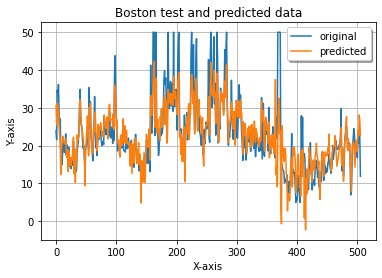

In [9]:
# Plotting the predicted results against actual result
mdata = lr_model.transform(va_df)

x_ax = range(0, mdata.count())
y_pred = mdata.select("prediction").collect()
y_orig = mdata.select("target").collect()  
 
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Boston test and predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

In [10]:
# If you do new executions of your code, do not forget to close the spark context session.
sc.stop()  